In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.table import Table, hstack
import lsst.pipe.base
import hugs_pipe as hp
from hugs_pipe import utils, imtools, primitives as prim
from hugs_pipe.cattools import cutter, xmatch

In [2]:
sam = Table.read('/home/jgreco/sample.csv')

In [3]:
def display_results(exp, sources, kws_list):
    v1 = hp.Viewer(data_id=exp)
    disp1 = v1.create_ds9_display(frame=1)
    disp1.setMaskPlaneColor('THRESH_HIGH', 'magenta')
    disp1.setMaskPlaneColor('THRESH_LOW', 'yellow')
    disp1.setMaskPlaneColor('CLEANED', 'white')
    disp1.setMaskPlaneColor('SEX_SEG', 'blue')
    v1.ds9_display_patch(frame=1, mask_trans=70, disp=disp1)
    for s, kws in zip(sources, kws_list):
        v1.ds9_draw_ell(s, frame=1, ellpars='sex', **kws)    

In [5]:
def run(cfg):
    
    cfg.timer
    
    ############################################################
    # Get masked image and check if we have enough good data
    ############################################################

    mi = cfg.exp[cfg.band_detect].getMaskedImage()
    mask = mi.getMask()
    
    ############################################################
    # Image thesholding at low and high thresholds. In both 
    # cases, the image is smoothed at the psf scale.
    ############################################################

    mi_smooth = imtools.smooth_gauss(mi, cfg.psf_sigma)
    cfg.logger.info('performing low threshold at '
                    '{} sigma'.format(cfg.thresh_low['thresh']))
    fpset_low = prim.image_threshold(
        mi_smooth, mask=mask, plane_name='THRESH_LOW', **cfg.thresh_low)
    cfg.logger.info('performing high threshold at '
                    '{} sigma'.format(cfg.thresh_high['thresh']))
    fpset_high = prim.image_threshold(
        mi_smooth, mask=mask, plane_name='THRESH_HIGH', **cfg.thresh_high)

    del mi_smooth

    ############################################################
    # Get "cleaned" image, with noise replacement
    ############################################################

    cfg.logger.info('generating cleaned exposure')
    exp_clean = prim.clean(cfg.exp[cfg.band_detect], fpset_low, **cfg.clean)
    mi_clean = exp_clean.getMaskedImage()
    mask_clean = mi_clean.getMask()
    
    ############################################################
    # Detect sources and measure props with SExtractor
    ############################################################

    cfg.logger.info('detecting in {}-band'.format(cfg.band_detect))
    label = '{}-{}-{}'.format(cfg.tract, cfg.patch[0], cfg.patch[-1])
    if cfg.group_id:
        label = str(cfg.group_id)+'-'+label

    cfg.sex_measure['sf'] = None
    num_aps = len(cfg.sex_measure['apertures'])

    cfg.logger.info('cleaning non-detection bands')
    replace = cfg.exp.get_mask_array(cfg.band_detect)
    for band in cfg.bands:
        if band!=cfg.band_detect:
            mi_band = cfg.exp[band].getMaskedImage()
            noise_array = utils.make_noise_image(mi_band, cfg.rng)
            mi_band.getImage().getArray()[replace] = noise_array[replace]

    sources = Table()

    for band in cfg.bands:
        cfg.logger.info('measuring in {}-band'.format(band))
        add_params = band==cfg.band_detect
        dual_exp = None if band==cfg.band_detect else cfg.exp[band]
        sources_band = prim.sex_measure(
            exp_clean, label=label+'-'+cfg.band_detect, add_params=add_params,
            dual_exp=dual_exp, **cfg.sex_measure)
        if len(sources_band)>0:
            utils.add_band_to_name(sources_band, band, num_aps)
            if band!=cfg.band_detect:
                cols = [c for c in sources_band.colnames if '('+band+')' in c]
                sources = hstack([sources, sources_band[cols]])
            else:
                sources = hstack([sources, sources_band])
        else:
            break
    
    if len(sources)>0:

        ############################################################
        # Verify detections in other bands using SExtractor
        ############################################################

        all_detections = sources.copy()

        for band in cfg.band_verify:
            cfg.logger.info('verifying dection in {}-band'.format(band))
            sources_verify = prim.sex_measure(
                cfg.exp[band], label=label+'-'+band,
                add_params=False, **cfg.sex_measure)
            if len(sources_verify)>0:
                match_masks, _ = xmatch(
                    sources, sources_verify, max_sep=cfg.verify_max_sep)
                txt = 'cuts: {} out of {} objects detected in {}-band'.format(
                    len(match_masks[0]), len(sources), band)
                cfg.logger.info(txt)
                if len(match_masks[0])==0:
                    sources = Table()
                    break
                sources = sources[match_masks[0]]
            else:
                sources = Table()
                break
                    
        if len(sources)>0:
            candy = cutter(sources.to_pandas(),
                           min_cuts=cfg.min_cuts,
                           max_cuts=cfg.max_cuts,
                           logger=cfg.logger)
            candy = Table.from_pandas(candy)

    cfg.logger.info('task completed in {:.2f} min'.format(cfg.timer))
    
    results = lsst.pipe.base.Struct(all_detections=all_detections,
                                        sources=sources,
                                        candy=candy,
                                        exp=cfg.exp,
                                        exp_clean=exp_clean)
    return results

In [6]:
tract, patch = 9348, '7,6'

In [7]:
try: config.reset_mask_planes()
except NameError: pass    
config = hp.Config(config_fn='explore-config.yml', tract=tract, patch=patch);

hugs-pipe: 9348 | 7,6: 05/25 11:31:42 INFO: starting hugs-pipe with config file explore-config.yml


INFO:hugs-pipe: 9348 | 7,6:starting hugs-pipe with config file explore-config.yml


In [8]:
results = run(config)

hugs-pipe: 9348 | 7,6: 05/25 11:31:52 INFO: performing low threshold at 3.0 sigma


INFO:hugs-pipe: 9348 | 7,6:performing low threshold at 3.0 sigma


hugs-pipe: 9348 | 7,6: 05/25 11:31:53 INFO: performing high threshold at 28.0 sigma


INFO:hugs-pipe: 9348 | 7,6:performing high threshold at 28.0 sigma


hugs-pipe: 9348 | 7,6: 05/25 11:31:54 INFO: generating cleaned exposure


INFO:hugs-pipe: 9348 | 7,6:generating cleaned exposure


hugs-pipe: 9348 | 7,6: 05/25 11:31:58 INFO: detecting in i-band


INFO:hugs-pipe: 9348 | 7,6:detecting in i-band


hugs-pipe: 9348 | 7,6: 05/25 11:31:58 INFO: cleaning non-detection bands


INFO:hugs-pipe: 9348 | 7,6:cleaning non-detection bands


hugs-pipe: 9348 | 7,6: 05/25 11:32:02 INFO: measuring in i-band


INFO:hugs-pipe: 9348 | 7,6:measuring in i-band



running 
-------
sex -c default.sex /scratch/network/jgreco/temp-io/sexin/exp-9348-7-6-i.fits[1] -CATALOG_NAME /scratch/network/jgreco/temp-io/sexout/sex-9348-7-6-i.cat -CHECKIMAGE_NAME /scratch/network/jgreco/temp-io/sexout/9348-7-6-i-SEGMENTATION.fits -PARAMETERS_NAME 9348-7-6-i.params -MEMORY_PIXSTACK 900000 -PHOT_FLUXFRAC 0.5 -MAG_ZEROPOINT 27.0 -PIXEL_SCALE 0.168 -PHOT_APERTURES 3,4,5,6,7,8,16,32 -THRESH_TYPE RELATIVE -WEIGHT_TYPE NONE -DETECT_THRESH 0.7 -FILTER Y -DETECT_MINAREA 100 -CHECKIMAGE_TYPE SEGMENTATION -FILTER_NAME gauss_6.0_31x31.conv -SEEING_FWHM 0.8 -VERBOSE_TYPE QUIET -BACK_SIZE 128

hugs-pipe: 9348 | 7,6: 05/25 11:32:27 INFO: measuring in r-band


INFO:hugs-pipe: 9348 | 7,6:measuring in r-band



running 
-------
sex -c default.sex /scratch/network/jgreco/temp-io/sexin/exp-9348-7-6-i.fits[1],/scratch/network/jgreco/temp-io/sexin/exp-9348-7-6-i-r.fits[1] -CATALOG_NAME /scratch/network/jgreco/temp-io/sexout/sex-9348-7-6-i-r.cat -CHECKIMAGE_NAME /scratch/network/jgreco/temp-io/sexout/9348-7-6-i-SEGMENTATION.fits -PARAMETERS_NAME 9348-7-6-i.params -MEMORY_PIXSTACK 900000 -PHOT_FLUXFRAC 0.5 -MAG_ZEROPOINT 27.0 -PIXEL_SCALE 0.168 -PHOT_APERTURES 3,4,5,6,7,8,16,32 -THRESH_TYPE RELATIVE -WEIGHT_TYPE NONE -DETECT_THRESH 0.7 -FILTER Y -DETECT_MINAREA 100 -CHECKIMAGE_TYPE SEGMENTATION -FILTER_NAME gauss_6.0_31x31.conv -SEEING_FWHM 0.8 -VERBOSE_TYPE QUIET -BACK_SIZE 128

hugs-pipe: 9348 | 7,6: 05/25 11:32:48 INFO: measuring in g-band


INFO:hugs-pipe: 9348 | 7,6:measuring in g-band



running 
-------
sex -c default.sex /scratch/network/jgreco/temp-io/sexin/exp-9348-7-6-i.fits[1],/scratch/network/jgreco/temp-io/sexin/exp-9348-7-6-i-g.fits[1] -CATALOG_NAME /scratch/network/jgreco/temp-io/sexout/sex-9348-7-6-i-g.cat -CHECKIMAGE_NAME /scratch/network/jgreco/temp-io/sexout/9348-7-6-i-SEGMENTATION.fits -PARAMETERS_NAME 9348-7-6-i.params -MEMORY_PIXSTACK 900000 -PHOT_FLUXFRAC 0.5 -MAG_ZEROPOINT 27.0 -PIXEL_SCALE 0.168 -PHOT_APERTURES 3,4,5,6,7,8,16,32 -THRESH_TYPE RELATIVE -WEIGHT_TYPE NONE -DETECT_THRESH 0.7 -FILTER Y -DETECT_MINAREA 100 -CHECKIMAGE_TYPE SEGMENTATION -FILTER_NAME gauss_6.0_31x31.conv -SEEING_FWHM 0.8 -VERBOSE_TYPE QUIET -BACK_SIZE 128

hugs-pipe: 9348 | 7,6: 05/25 11:33:10 INFO: verifying dection in g-band


INFO:hugs-pipe: 9348 | 7,6:verifying dection in g-band



running 
-------
sex -c default.sex /scratch/network/jgreco/temp-io/sexin/exp-9348-7-6-g.fits[1] -CATALOG_NAME /scratch/network/jgreco/temp-io/sexout/sex-9348-7-6-g.cat -CHECKIMAGE_NAME /scratch/network/jgreco/temp-io/sexout/9348-7-6-g-SEGMENTATION.fits -PARAMETERS_NAME 9348-7-6-g.params -MEMORY_PIXSTACK 900000 -PHOT_FLUXFRAC 0.5 -MAG_ZEROPOINT 27.0 -PIXEL_SCALE 0.168 -PHOT_APERTURES 3,4,5,6,7,8,16,32 -THRESH_TYPE RELATIVE -WEIGHT_TYPE NONE -DETECT_THRESH 0.7 -FILTER Y -DETECT_MINAREA 100 -CHECKIMAGE_TYPE SEGMENTATION -FILTER_NAME gauss_6.0_31x31.conv -SEEING_FWHM 0.8 -VERBOSE_TYPE QUIET -BACK_SIZE 128

hugs-pipe: 9348 | 7,6: 05/25 11:33:30 INFO: cuts: 977 out of 1583 objects detected in g-band


INFO:hugs-pipe: 9348 | 7,6:cuts: 977 out of 1583 objects detected in g-band


hugs-pipe: 9348 | 7,6: 05/25 11:33:30 INFO: cuts: 977 objects in cat before cuts


INFO:hugs-pipe: 9348 | 7,6:cuts: 977 objects in cat before cuts


hugs-pipe: 9348 | 7,6: 05/25 11:33:30 INFO: cuts: will cut 959 objects with FWHM_IMAGE(i) <= 25


INFO:hugs-pipe: 9348 | 7,6:cuts: will cut 959 objects with FWHM_IMAGE(i) <= 25


hugs-pipe: 9348 | 7,6: 05/25 11:33:30 INFO: cuts: will cut 9 objects with num_edge_pix >= 1


INFO:hugs-pipe: 9348 | 7,6:cuts: will cut 9 objects with num_edge_pix >= 1


hugs-pipe: 9348 | 7,6: 05/25 11:33:30 INFO: cuts: 18 objects in cat after cuts


INFO:hugs-pipe: 9348 | 7,6:cuts: 18 objects in cat after cuts


hugs-pipe: 9348 | 7,6: 05/25 11:33:30 INFO: task completed in 1.66 min


INFO:hugs-pipe: 9348 | 7,6:task completed in 1.66 min


In [20]:

sources = results.all_detections[results.all_detections['A_IMAGE(i)']>3]

display_results(results.exp_clean, [sources, results.candy], 
                [{'ec':'red', 'scale':3}, {'ec':'blue', 'scale':5}])

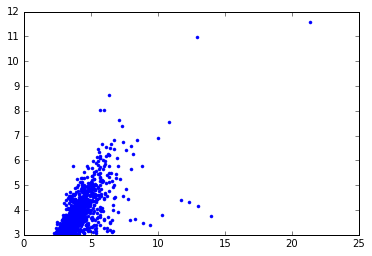

In [21]:
plt.plot(sources['FLUX_RADIUS(i)'],sources['A_IMAGE(i)'], '.')

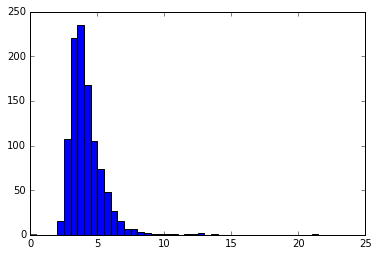

In [23]:
plt.hist(sources['FLUX_RADIUS(i)'], bins=50, range=[0,25]);

In [15]:
s = results.all_detections['A_IMAGE(i)']
sb = results.all_detections['B_IMAGE(i)']

s.min(), s.max(), np.median(s), s.mean()

(2.1739999999999999, 11.584, 3.2770000000000001, 3.5273891345546429)

In [16]:
sb.min(), sb.max(), np.median(sb), sb.mean()

(1.7410000000000001,
 6.7110000000000003,
 2.5720000000000001,
 2.6727372078332281)

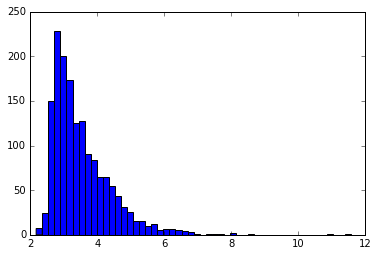

In [18]:
plt.hist(s, bins='auto');

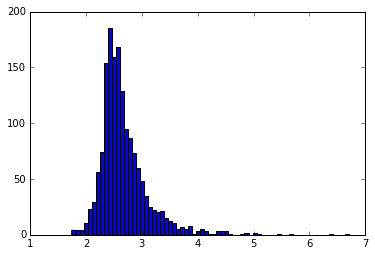

In [19]:
plt.hist(sb, bins='auto');